# Sevag Baghdassarian (260980928)
## COMP 579 Final Project: Reimplementation of Hado van Hasselt’s Double Q-learning

See the `envs` folder for the implementations of the environments used in this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from envs.GridWorldEnv import GridWorldEnv

Global constants

In [2]:
GAMMA = 0.95 # discount factor was 0.95 for all experiments in the original paper
MAX_STEPS = 10000 # number of steps to trace running average of rewards (10000 in the original paper)

### Implementing the learner functions

As in the Double Q-learning paper, the Q-learning and Double Q-learning agents are implemented with an $\epsilon$-greedy exploration with $\epsilon = 1/\sqrt{n(s)}$, where $n(s)$ is the number of times state $s$ is visited by the agent. 

The learning rate $\alpha$ is determined by $\alpha = 1/n(s,a)$ (mode 1) or $\alpha = 1/n(s,a)^{0.8}$ (mode 2), where $n(s,a)$ corresponds to the number of times a given state-action pair is visited.

In [3]:
def get_epsilon(n):
    '''
    Function to calculate epsilon based on the number of times a state is visited.
    '''
    return 1 / np.sqrt(n)

In [4]:
def get_lr(n, mode):
    '''
    Function to calculate the learning rate based on the number of times a state-action pair is visited, and the mode.
    '''
    if mode == 1:
        alpha = 1/n
    elif mode == 2:
        alpha = 1/(n**0.8)
    return alpha

#### Q-learning

In [5]:
def Q_learning(env, n_episodes, mode):
    '''
    Implementation of the Q-learning algorithm.
    '''
    
    # create Q table
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    # variables to keep track of reward running average for first MAX_STEPS number of steps
    running_avg_per_step = []
    running_avg = 0
    total_steps_taken = 0

    # variables to keep track of max Q(S,a) for the starting state over all episodes
    running_avg_max_Q_per_step = []
    running_avg_max_Q = 0

    for episode in tqdm(range(n_episodes)):
        
        # keep track of number of times a state is visited (used to calculate epislon)
        n_s = np.zeros(env.observation_space.n)

        # keep track of number of times a state-action pair is visited (used to calculate alpha)
        n_s_a = np.zeros((env.observation_space.n, env.action_space.n))

        # reset env
        state, _ = env.reset()
        
        # update n_s for initial state
        n_s[state] += 1

        # for starting state: get maximal Q value, get running average
        max_starting_Q = np.max(Q[state])
        running_avg_max_Q = (total_steps_taken * running_avg_max_Q + max_starting_Q) / (total_steps_taken + 1)
        running_avg_max_Q_per_step.append(running_avg_max_Q)

        terminated = False

        while not terminated:

            # epsilon-greedy exploration
            epsilon = get_epsilon(n_s[state])

            if np.random.rand() < epsilon:
                # random action
                action = env.action_space.sample()
            else:
                # greedy action
                max = np.where(np.max(Q[state]) == Q[state])[0]
                # in case there are ties, pick randomly
                action = np.random.choice(max)

            # step and get reward
            next_state, reward, terminated, _ = env.step(action)

            # update n_s for new state
            n_s[next_state] += 1

            # update n_s_a for (state, action)
            n_s_a[state, action] += 1

            # get learning rate alpha
            alpha = get_lr(n_s_a[state, action], mode)

            # update Q table
            Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + GAMMA * np.max(Q[next_state]))
            
            # update state to be next state
            state = next_state

            # calculate running average of rewards for first MAX_STEPS steps
            if total_steps_taken < MAX_STEPS:
                running_avg = (total_steps_taken * running_avg + reward) / (total_steps_taken + 1)
                running_avg_per_step.append(running_avg)
                
            total_steps_taken += 1

    return running_avg_per_step, running_avg_max_Q_per_step

#### Double Q-learning

In [6]:
def Double_Q_learning(env, n_episodes, mode):
    '''
    Implementation of the Double Q-learning algorithm.
    '''
    
    # create Q_a, Q_b tables
    Q_a = np.zeros((env.observation_space.n, env.action_space.n))
    Q_b = np.zeros((env.observation_space.n, env.action_space.n))

    # variables to keep track of reward running average for first MAX_STEPS number of steps
    running_avg_per_step = []
    running_avg = 0
    total_steps_taken = 0

    # variables to keep track of max Q(S,a) for the starting state over all episodes
    running_avg_max_Q_per_step = []
    running_avg_max_Q = 0

    for episode in tqdm(range(n_episodes)):

        # for double Q-learning, as the original paper states, the variable used for the learning rate is:
        # n(s,a) = n_a(s,a) if Q_a is updated
        # otherwise, n(s,a) = n_b(s,a)
        n_s_a_Qa = np.zeros((env.observation_space.n, env.action_space.n))
        n_s_a_Qb = np.zeros((env.observation_space.n, env.action_space.n))

        # keep track of number of times a state is visited (used to calculate epislon)
        n_s = np.zeros(env.observation_space.n)

        # keep track of number of times a state-action pair is visited (used to calculate alpha)
        n_s_a = np.zeros((env.observation_space.n, env.action_space.n))
        
        # reset env
        state, _ = env.reset()

        # update n_s for initial state
        n_s[state] += 1

        # for starting state: get maximal Q value, get running average
        max_starting_Q_a = np.max(Q_a[state])
        max_starting_Q_b = np.max(Q_a[state])
        max_starting_Q = max_starting_Q_a if max_starting_Q_a > max_starting_Q_b else max_starting_Q_b
        running_avg_max_Q = (total_steps_taken * running_avg_max_Q + max_starting_Q) / (total_steps_taken + 1)
        running_avg_max_Q_per_step.append(running_avg_max_Q)

        terminated = False

        while not terminated:
            
            # epsilon-greedy exploration
            epsilon = get_epsilon(n_s[state])
            
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                # get action with maximal Q value per Double Q-learning
                Q = Q_a[state] + Q_b[state]
                max = np.where(np.max(Q) == Q)[0]
                action = np.random.choice(max)

            # apply action, get reward
            next_state, reward, terminated, _ = env.step(action)
            
            # update n_s for new state
            n_s[next_state] += 1

            # update n_s_a for (state, action)
            n_s_a[state, action] += 1

            # update A or B with equal probability
            if np.random.rand() < 0.5:
                # update Q_a
                # increment count for (state, action) pair matrix for Qa
                n_s_a_Qa[state, action] = n_s_a_Qa[state, action] + 1
                # get alpha
                alpha = get_lr(n_s_a_Qa[state, action], mode)
                c = alpha * (reward + GAMMA * Q_b[next_state, np.argmax(Q_a[next_state])] - Q_a[state, action])
                Q_a[state, action] = Q_a[state, action] + c
            else:
                # update Q_b
                # increment count for (state, action) pair matrix for Qb
                n_s_a_Qb[state, action] = n_s_a_Qb[state, action] + 1
                # get alpha
                alpha = get_lr(n_s_a_Qb[state, action], mode)
                c = alpha * (reward + GAMMA * Q_a[next_state, np.argmax(Q_b[next_state])] - Q_b[state, action])
                Q_b[state, action] = Q_b[state, action] + c

            # update state to be next state
            state = next_state

            # calculate running average of rewards for first MAX_STEPS steps
            if total_steps_taken < MAX_STEPS:
                running_avg = (total_steps_taken * running_avg + reward) / (total_steps_taken + 1)
                running_avg_per_step.append(running_avg)
                
            total_steps_taken += 1

    return running_avg_per_step, running_avg_max_Q_per_step


### Running the Grid World experiments 

Helper function to plot graphs.

In [7]:
def plot_graphs(Q_learning_mode_1_running_avg_per_step_3x3, Double_Q_learning_mode_1_running_avg_per_step_3x3, 
                Q_learning_mode_2_running_avg_per_step_3x3, Double_Q_learning_mode_2_running_avg_per_step_3x3,
                Q_learning_mode_1_running_avg_max_Q_per_step_3x3, Double_Q_learning_mode_1_running_avg_max_Q_per_step_3x3,
                Q_learning_mode_2_running_avg_max_Q_per_step_3x3, Double_Q_learning_mode_2_running_avg_max_Q_per_step_3x3,
                title):
    fig, axs = plt.subplots(2, 2)

    fig.suptitle(title)

    axs[0, 0].set_title(r'$\alpha = 1/n(s,a)$')
    axs[0, 0].plot(np.arange(MAX_STEPS), Q_learning_mode_1_running_avg_per_step_3x3, linewidth=1, label='Q')
    axs[0, 0].plot(np.arange(MAX_STEPS), Double_Q_learning_mode_1_running_avg_per_step_3x3, linewidth=1, label='Double Q')
    axs[0, 0].set_xlim(0, 10000)
    axs[0, 0].set_ylim(-1.5, 0.5)
    axs[0, 0].set_ylabel(r'$r$ per step')
    axs[0, 0].legend()

    axs[0, 1].set_title(r'$\alpha = 1/n(s,a)^{0.8}$')
    axs[0, 1].plot(np.arange(MAX_STEPS), Q_learning_mode_2_running_avg_per_step_3x3, linewidth=1)
    axs[0, 1].plot(np.arange(MAX_STEPS), Double_Q_learning_mode_2_running_avg_per_step_3x3, linewidth=1)
    axs[0, 1].set_xlim(0, 10000)
    axs[0, 1].set_ylim(-1.5, 0.5)

    axs[1, 0].set_ylabel(r'$max_{a} Q(S, a)$')
    axs[1, 0].set_xlabel('Number of steps')
    axs[1, 0].plot(np.arange(MAX_STEPS), Q_learning_mode_1_running_avg_max_Q_per_step_3x3, linewidth=1)
    axs[1, 0].plot(np.arange(MAX_STEPS), Double_Q_learning_mode_1_running_avg_max_Q_per_step_3x3, linewidth=1)
    axs[1, 0].set_xlim(0, 10000)

    axs[1, 1].set_xlabel('Number of steps')
    axs[1, 1].plot(np.arange(MAX_STEPS), Q_learning_mode_2_running_avg_max_Q_per_step_3x3, linewidth=1)
    axs[1, 1].plot(np.arange(MAX_STEPS), Double_Q_learning_mode_2_running_avg_max_Q_per_step_3x3, linewidth=1)
    axs[1, 1].set_xlim(0, 10000)

#### 3x3 Grid World

Run both algorithms and generate plots.

100%|██████████| 10000/10000 [00:03<00:00, 2888.48it/s]


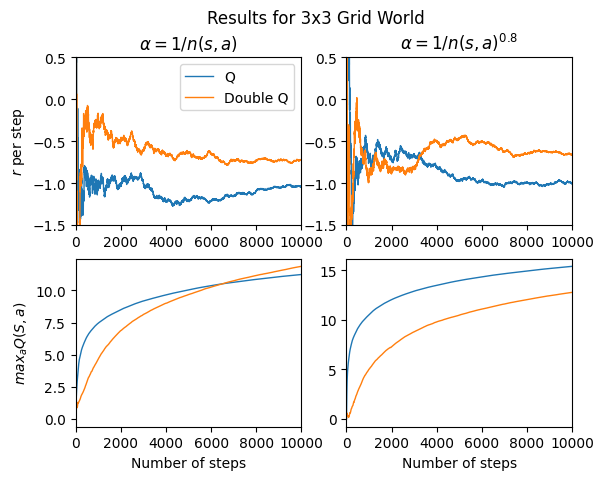

In [30]:
env3x3 = GridWorldEnv(height=3, width=3)

Q_learning_mode_1_running_avg_per_step_3x3, Q_learning_mode_1_running_avg_max_Q_per_step_3x3 = Q_learning(env=env3x3, n_episodes=10000, mode=1)
Q_learning_mode_2_running_avg_per_step_3x3, Q_learning_mode_2_running_avg_max_Q_per_step_3x3 = Q_learning(env=env3x3, n_episodes=10000, mode=2)

Double_Q_learning_mode_1_running_avg_per_step_3x3, Double_Q_learning_mode_1_running_avg_max_Q_per_step_3x3 = Double_Q_learning(env=env3x3, n_episodes=10000, mode=1)
Double_Q_learning_mode_2_running_avg_per_step_3x3, Double_Q_learning_mode_2_running_avg_max_Q_per_step_3x3 = Double_Q_learning(env=env3x3, n_episodes=10000, mode=2)

plot_graphs(Q_learning_mode_1_running_avg_per_step_3x3, Double_Q_learning_mode_1_running_avg_per_step_3x3, 
                Q_learning_mode_2_running_avg_per_step_3x3, Double_Q_learning_mode_2_running_avg_per_step_3x3,
                Q_learning_mode_1_running_avg_max_Q_per_step_3x3, Double_Q_learning_mode_1_running_avg_max_Q_per_step_3x3,
                Q_learning_mode_2_running_avg_max_Q_per_step_3x3, Double_Q_learning_mode_2_running_avg_max_Q_per_step_3x3,
                'Results for 3x3 Grid World')

#### 4x4 Grid World

Run both algorithms and generate plots.

100%|██████████| 10000/10000 [00:10<00:00, 931.31it/s]


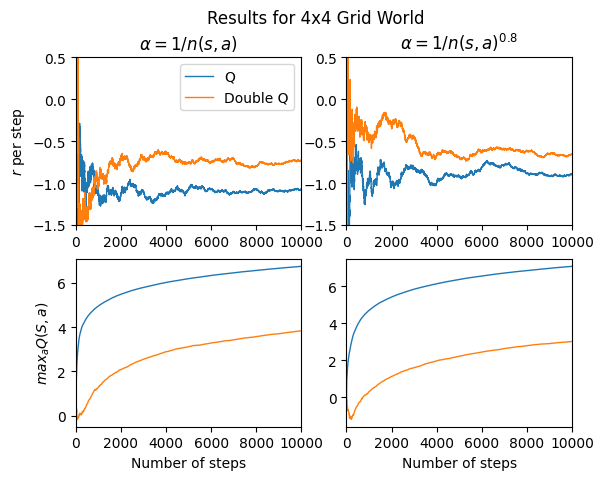

In [12]:
env4x4 = GridWorldEnv(height=4, width=4)

Q_learning_mode_1_running_avg_per_step_4x4, Q_learning_mode_1_running_avg_max_Q_per_step_4x4 = Q_learning(env=env4x4, n_episodes=10000, mode=1)
Q_learning_mode_2_running_avg_per_step_4x4, Q_learning_mode_2_running_avg_max_Q_per_step_4x4 = Q_learning(env=env4x4, n_episodes=10000, mode=2)

Double_Q_learning_mode_1_running_avg_per_step_4x4, Double_Q_learning_mode_1_running_avg_max_Q_per_step_4x4 = Double_Q_learning(env=env4x4, n_episodes=10000, mode=1)
Double_Q_learning_mode_2_running_avg_per_step_4x4, Double_Q_learning_mode_2_running_avg_max_Q_per_step_4x4 = Double_Q_learning(env=env4x4, n_episodes=10000, mode=2)

plot_graphs(Q_learning_mode_1_running_avg_per_step_4x4, Double_Q_learning_mode_1_running_avg_per_step_4x4, 
                Q_learning_mode_2_running_avg_per_step_4x4, Double_Q_learning_mode_2_running_avg_per_step_4x4,
                Q_learning_mode_1_running_avg_max_Q_per_step_4x4, Double_Q_learning_mode_1_running_avg_max_Q_per_step_4x4,
                Q_learning_mode_2_running_avg_max_Q_per_step_4x4, Double_Q_learning_mode_2_running_avg_max_Q_per_step_4x4,
                'Results for 4x4 Grid World')

#### 5x5 Grid World

Run both algorithms and generate plots.

100%|██████████| 10000/10000 [00:17<00:00, 571.47it/s]


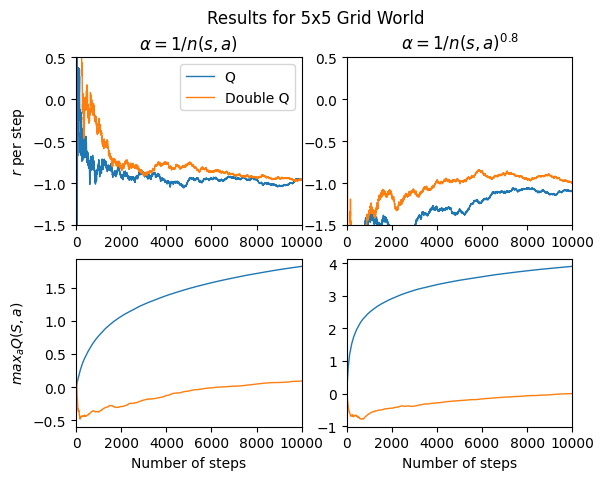

In [14]:
env5x5 = GridWorldEnv(height=5, width=5)

Q_learning_mode_1_running_avg_per_step_5x5, Q_learning_mode_1_running_avg_max_Q_per_step_5x5 = Q_learning(env=env5x5, n_episodes=10000, mode=1)
Q_learning_mode_2_running_avg_per_step_5x5, Q_learning_mode_2_running_avg_max_Q_per_step_5x5 = Q_learning(env=env5x5, n_episodes=10000, mode=2)

Double_Q_learning_mode_1_running_avg_per_step_5x5, Double_Q_learning_mode_1_running_avg_max_Q_per_step_5x5 = Double_Q_learning(env=env5x5, n_episodes=10000, mode=1)
Double_Q_learning_mode_2_running_avg_per_step_5x5, Double_Q_learning_mode_2_running_avg_max_Q_per_step_5x5 = Double_Q_learning(env=env5x5, n_episodes=10000, mode=2)

plot_graphs(Q_learning_mode_1_running_avg_per_step_5x5, Double_Q_learning_mode_1_running_avg_per_step_5x5, 
                Q_learning_mode_2_running_avg_per_step_5x5, Double_Q_learning_mode_2_running_avg_per_step_5x5,
                Q_learning_mode_1_running_avg_max_Q_per_step_5x5, Double_Q_learning_mode_1_running_avg_max_Q_per_step_5x5,
                Q_learning_mode_2_running_avg_max_Q_per_step_5x5, Double_Q_learning_mode_2_running_avg_max_Q_per_step_5x5,
                'Results for 5x5 Grid World')

#### 6x6 Grid World

Run both algorithms and generate plots.

100%|██████████| 10000/10000 [00:27<00:00, 366.25it/s]


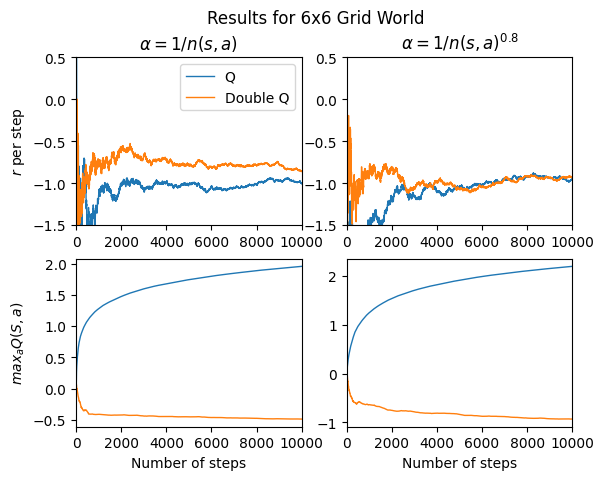

In [18]:
env6x6 = GridWorldEnv(height=6, width=6)

Q_learning_mode_1_running_avg_per_step_6x6, Q_learning_mode_1_running_avg_max_Q_per_step_6x6 = Q_learning(env=env6x6, n_episodes=10000, mode=1)
Q_learning_mode_2_running_avg_per_step_6x6, Q_learning_mode_2_running_avg_max_Q_per_step_6x6 = Q_learning(env=env6x6, n_episodes=10000, mode=2)

Double_Q_learning_mode_1_running_avg_per_step_6x6, Double_Q_learning_mode_1_running_avg_max_Q_per_step_6x6 = Double_Q_learning(env=env6x6, n_episodes=10000, mode=1)
Double_Q_learning_mode_2_running_avg_per_step_6x6, Double_Q_learning_mode_2_running_avg_max_Q_per_step_6x6 = Double_Q_learning(env=env6x6, n_episodes=10000, mode=2)

plot_graphs(Q_learning_mode_1_running_avg_per_step_6x6, Double_Q_learning_mode_1_running_avg_per_step_6x6, 
                Q_learning_mode_2_running_avg_per_step_6x6, Double_Q_learning_mode_2_running_avg_per_step_6x6,
                Q_learning_mode_1_running_avg_max_Q_per_step_6x6, Double_Q_learning_mode_1_running_avg_max_Q_per_step_6x6,
                Q_learning_mode_2_running_avg_max_Q_per_step_6x6, Double_Q_learning_mode_2_running_avg_max_Q_per_step_6x6,
                'Results for 6x6 Grid World')